---

# <b> 창원 AI 아카데미: 데이터 분석 해커톤

* 일시: 2023년 7월 10일 ~ 12일
* 참가자: 백종환 </b>

<br>

---

---
# <b> * 문제 * </b>

### <b> *2012년부터 2021년까지의 창원시 표준지공시지가를 이용하여 2022년 창원시 표준지공시지가를 예측하시오.* </b>
---

## <b> 1. 데이터 전처리 </b>

> 필요 **라이브러리** 호출

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import iplot, init_notebook_mode

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

### 파일 불러오기
> 다수의 csv 파일에서 필요한 부분만 추출해서 하나로 합침.

In [3]:
df_list = []
for i in range(2012, 2022):
    if i == 2016:
        df = pd.read_csv("2016년 표준지 공시지가.csv", encoding='cp949')
        # df = pd.read_csv('/users/jjong/desktop/vscode/CWNU_ICT/창원AI아카데미(데이터분석 해커톤)/2016년 표준지 공시지가.csv', encoding='cp949')
        df['시도명'] = df['시도']
        df['시군구명'] = df['시군구.1']
        df['소재지'] = df['동리']
        df['지리적위치2'] = df['지리적위치']
        df['형상명'] = df['형상']
        df['지세명'] = df['지세']
        df['용도지역1'] = df['용도지역']
        df = df.drop(['시도', '시군구.1', '동리', '지리적위치', '형상', '지세', '용도지역', '읍면', '본번지.1', '부번지.1', '지번구분.1','부번지'], axis=1)
        df['연도'] = pd.to_datetime(i, format='%Y').year
        df_list.append(df)
    else:
        try:
            df = pd.read_csv(f"{i}년 표준지 공시지가.csv", encoding='cp949')
            # df = pd.read_csv(f'/users/jjong/desktop/vscode/CWNU_ICT/창원AI아카데미(데이터분석 해커톤)/{i}년 표준지 공시지가.csv', encoding='cp949')
            df['연도'] = pd.to_datetime(i, format='%Y').year
            df_list.append(df)
        except UnicodeDecodeError:
            df = pd.read_csv(f"{i}년 표준지 공시지가.csv", encoding='utf-8')
            # df = pd.read_csv(f'/users/jjong/desktop/vscode/CWNU_ICT/창원AI아카데미(데이터분석 해커톤)/{i}년 표준지 공시지가.csv', encoding='utf-8')
            df['연도'] = pd.to_datetime(i, format='%Y').year
            df_list.append(df)

data = pd.concat(df_list, ignore_index=True)
data.head()

,일련번호,시군구,읍면동리,지번구분,본번지,부번지,시도명,시군구명,소재지,지목,...,이용상황,주위환경,지세명,형상명,도로교통,공시지가,지리적위치1,지리적위치2,방위,연도
0,1,11110,10100,1,0003,0052,서울특별시,종로구,청운동 3-52,공원,...,공원등,시가지주변 야산지대,급경사지,부정형,세로(불),346000,경기상고,북측 인근,NaN,2012
1,2,11110,10100,1,0004,0015,서울특별시,종로구,청운동 4-15,대,...,단독주택,기존 주택지대,완경사지,사다리형,세로(가),2300000,경기상고,북서측 인근,북동향,2012
2,3,11110,10100,1,0008,0009,서울특별시,종로구,청운동 8-9,대,...,연립주택,일반 주택지대,급경사지,부정형,세로(가),2150000,청운중학교,서측인근,남향,2012
3,4,11110,10100,1,0015,0012,서울특별시,종로구,청운동 15-12,대,...,단독주택,고급 주택지대,평지,사다리형,소로각지,3280000,청운중학교,북서측인근,서향,2012
4,5,11110,10100,1,0015,0013,서울특별시,종로구,청운동 15-13,대,...,단독주택,고급 주택지대,완경사지,세로장방형,세로(가),2880000,경기상고,북측인근,북향,2012


In [6]:
df_2022 = pd.read_csv("2022년 표준지 공시지가.csv", encoding='utf-8')
# df_2022 = pd.read_csv(f'/users/jjong/desktop/vscode/CWNU_ICT/창원AI아카데미(데이터분석 해커톤)/2022년 표준지 공시지가.csv', encoding='utf-8')

df_2022['연도'] = pd.to_datetime(2022, format='%Y').year
df_2022 = df_2022.drop(['용도지역2', '지리적위치1', '지리적위치2', '방위'], axis=1)
df_2022.loc[df_2022['시군구명'].isna(), '시군구명'] = '세종특별자치시'
df_2022 = df_2022.iloc[:, 1:]
df_2022 = df_2022[df_2022['시군구명'].str.contains('창원')]

In [7]:
original = data.iloc[:, 1:].copy()
original = original.drop(['용도지역2', '지리적위치1', '지리적위치2', '방위'], axis=1)

# 창원시 데이터만 불러오기 및 결측치 확인

In [9]:
# 창원시 데이터만 불러오기
filtered_data = original[(original['시도명'].str.contains('경상남도'))]
filtered_data = filtered_data[filtered_data['시군구명'].str.contains('창원')]
df = filtered_data.copy()
df['가격'] = df['면적'] * df['공시지가']
df.head()

,시군구,읍면동리,지번구분,본번지,부번지,시도명,시군구명,소재지,지목,면적,용도지역1,이용상황,주위환경,지세명,형상명,도로교통,공시지가,연도,가격
431093,48121,10100,1,0006,0000,경상남도,창원의창구,북동 6,대,159.0,제1종일반주거지역,단독주택,기존 주택지대,완경사지,사다리형,세각(불),410000,2012,65190000.0
431094,48121,10100,1,0028,0000,경상남도,창원의창구,북동 28,대,182.0,제1종일반주거지역,다세대,기존 주택지대,평지,사다리형,소로한면,540000,2012,98280000.0
431095,48121,10100,1,0072,0000,경상남도,창원의창구,북동 72,대,162.0,제1종일반주거지역,단독주택,기존 주택지대,평지,부정형,세로(불),450000,2012,72900000.0
431096,48121,10100,1,0090,0002,경상남도,창원의창구,북동 90-2,대,147.0,제1종일반주거지역,단독주택,기존 주택지대,평지,부정형,소로한면,555000,2012,81585000.0
431097,48121,10100,1,0100,0002,경상남도,창원의창구,북동 100-2,대,180.0,제1종일반주거지역,단독주택,기존 주택지대,평지,부정형,소로한면,590000,2012,106200000.0


## <b> 2. 탐색적 자료 분석 및 특징 선택 EDA</b>

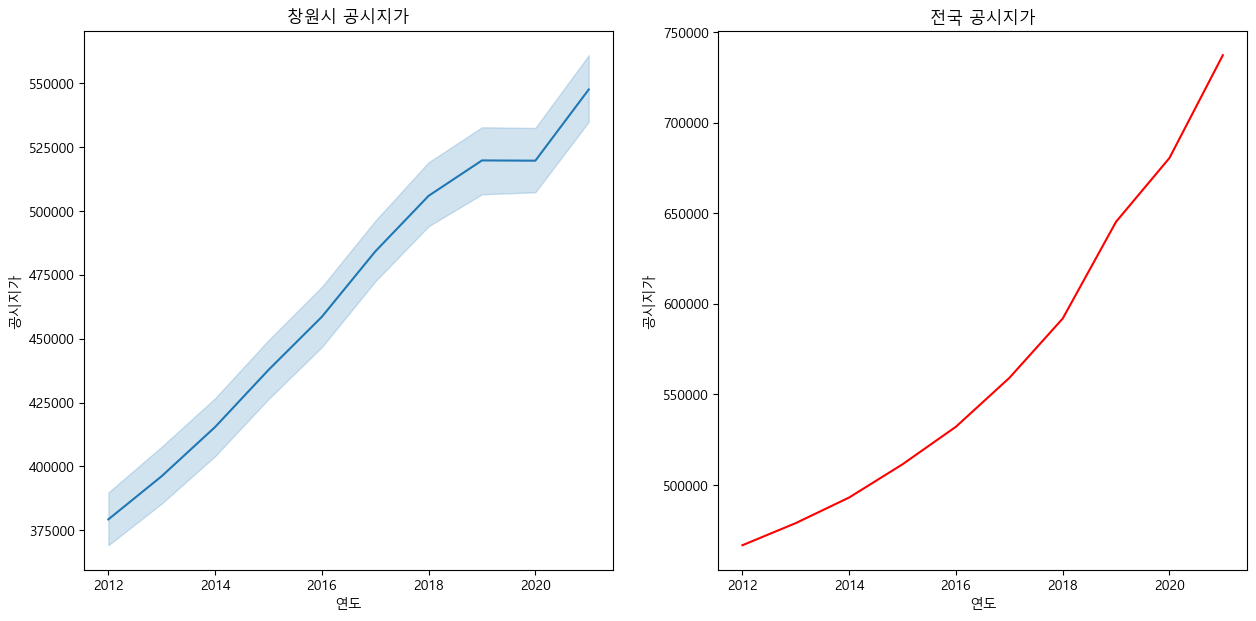

In [49]:
ori = original.groupby('연도')['공시지가'].mean().reset_index()
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.lineplot(x='연도', y='공시지가', data=df, ax=ax[0])
ax[0].set_title('창원시 공시지가')
sns.lineplot(x='연도', y='공시지가', data=ori, ax=ax[1], color='red')
ax[1].set_title('전국 공시지가')
plt.show()

### <u>지목</u>별 분석
> 박스플롯과 원그래프로 공시지가를 시각화하고 분석함.

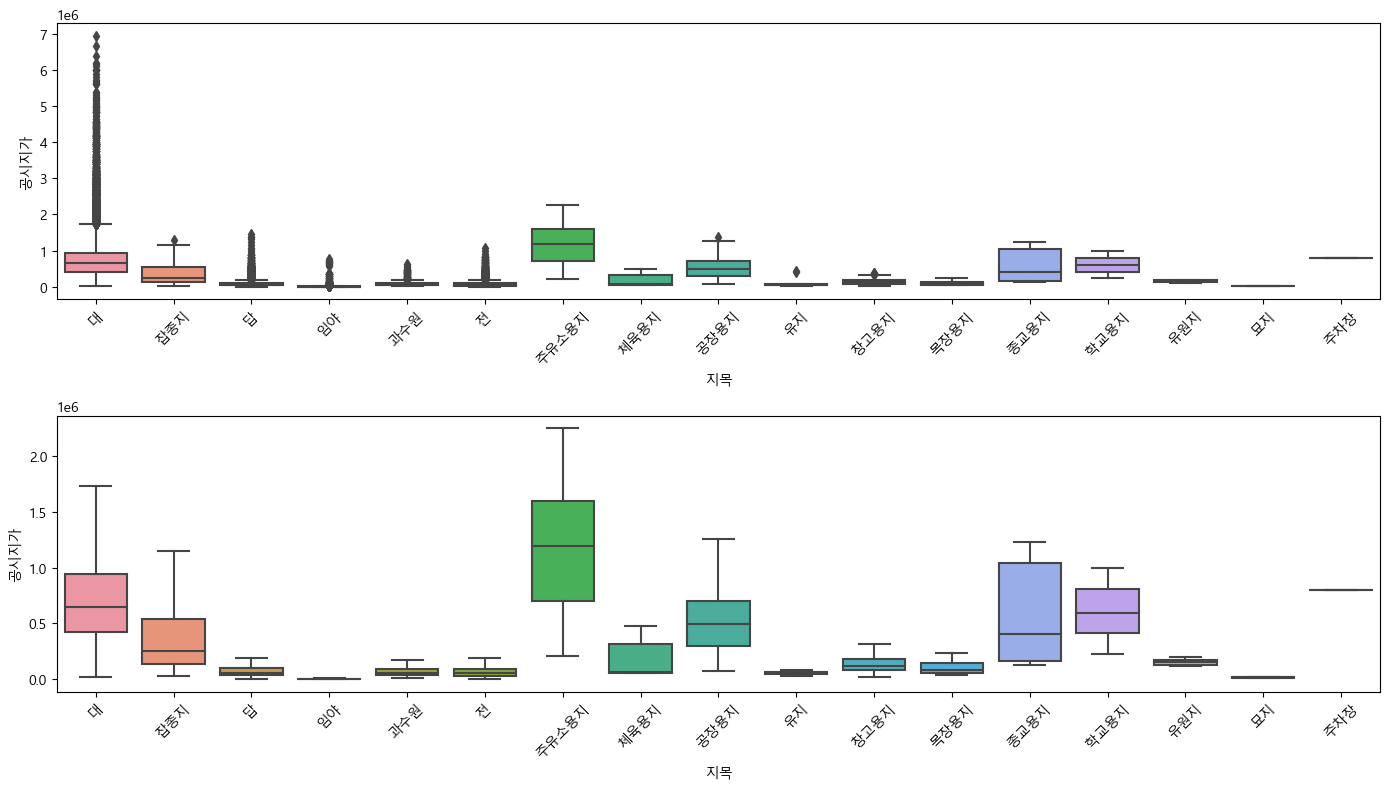

In [86]:
fig, axes = plt.subplots(2, 1, figsize=(14,8))
sns.boxplot(data=df, x='지목', y='공시지가', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
sns.boxplot(data=df, x='지목', y='공시지가', showfliers=False, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

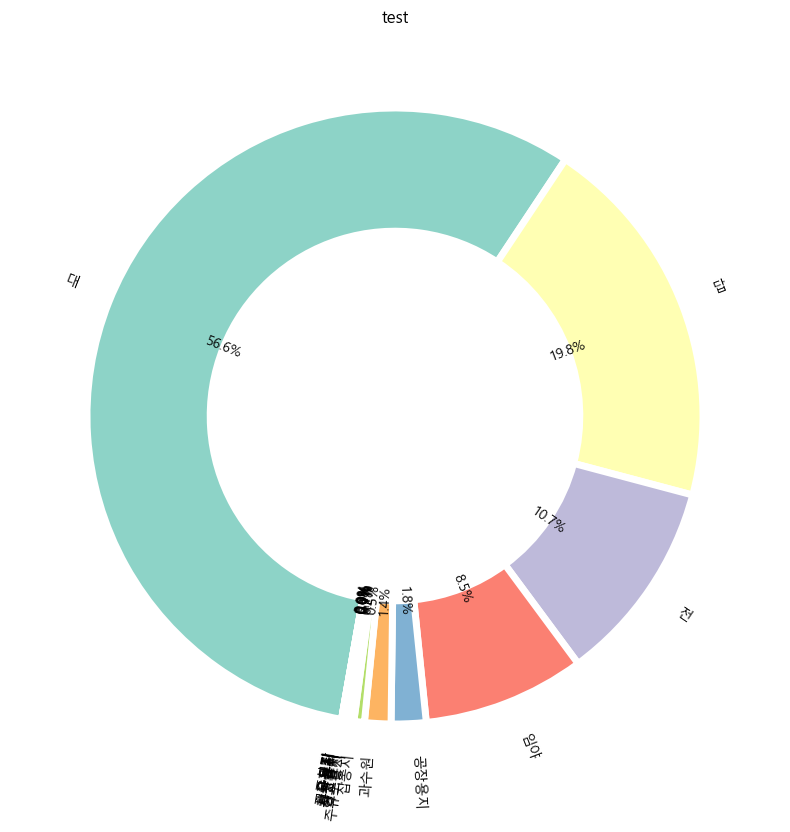

In [87]:
price_by_city = df['지목'].value_counts().sort_values(ascending=False)
ratio = price_by_city.values
labels = price_by_city.index
colors = plt.get_cmap('Set3').colors
wedgeprops={'width': 0.4, 'edgecolor': 'w', 'linewidth': 5}

plt.figure(figsize=(10, 10))
patches, labels, pct_texts = plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, 
        counterclock=False, colors=colors, wedgeprops=wedgeprops, rotatelabels=True)

for label, pct_text in zip(labels, pct_texts):
    pct_text.set_rotation(label.get_rotation())

plt.title('test')
plt.show()

In [88]:
jimok_value = df['지목'].value_counts()

fig = go.Figure(data=[go.Pie(labels=df['지목'].unique(), values=jimok_value, hole=0.4)])
fig.update_layout(width=700, height=600, title={
    'text': '창원시 지목별 분포',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 20}
})
# Display the figure in the notebook
fig.show()

In [90]:
# # 연도별 공시지가 흐름
# fig, ax = plt.subplots(5, 2, figsize=(15, 15))
# for i in range(2012, 2022):
#     sns.histplot(df[df['연도'] == i]['공시지가'], ax=ax[(i-2012)//2, (i-2012)%2], kde=True)
#     ax[(i-2012)//2, (i-2012)%2].set_title(f'Year {i}')
#     ax[(i-2012)//2, (i-2012)%2].set_xlabel('공시지가')
#     ax[(i-2012)//2, (i-2012)%2].set_ylabel('Count')

# plt.tight_layout()
# plt.show()

In [91]:
jimok_year = df.groupby(['연도', '지목'])['공시지가'].mean().reset_index()

# 그래프 그리기
fig = px.bar(jimok_year, x='지목', y='공시지가', animation_frame='연도', range_y=[0, max(jimok_year['공시지가'])],
             color='지목', labels={'지목': '지목', '공시지가': '공시지가'},
             title='지목별 공시지가 변화')
fig.update_layout(width=1200, height=600,
    xaxis={'categoryorder': 'array', 'categoryarray': ['A', 'B', 'C']},
                  title={
    'text': '지목별 공시지가 평균의 변화',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 20}
})
fig.update_layout()
fig.show()

# 용도지역별 분석

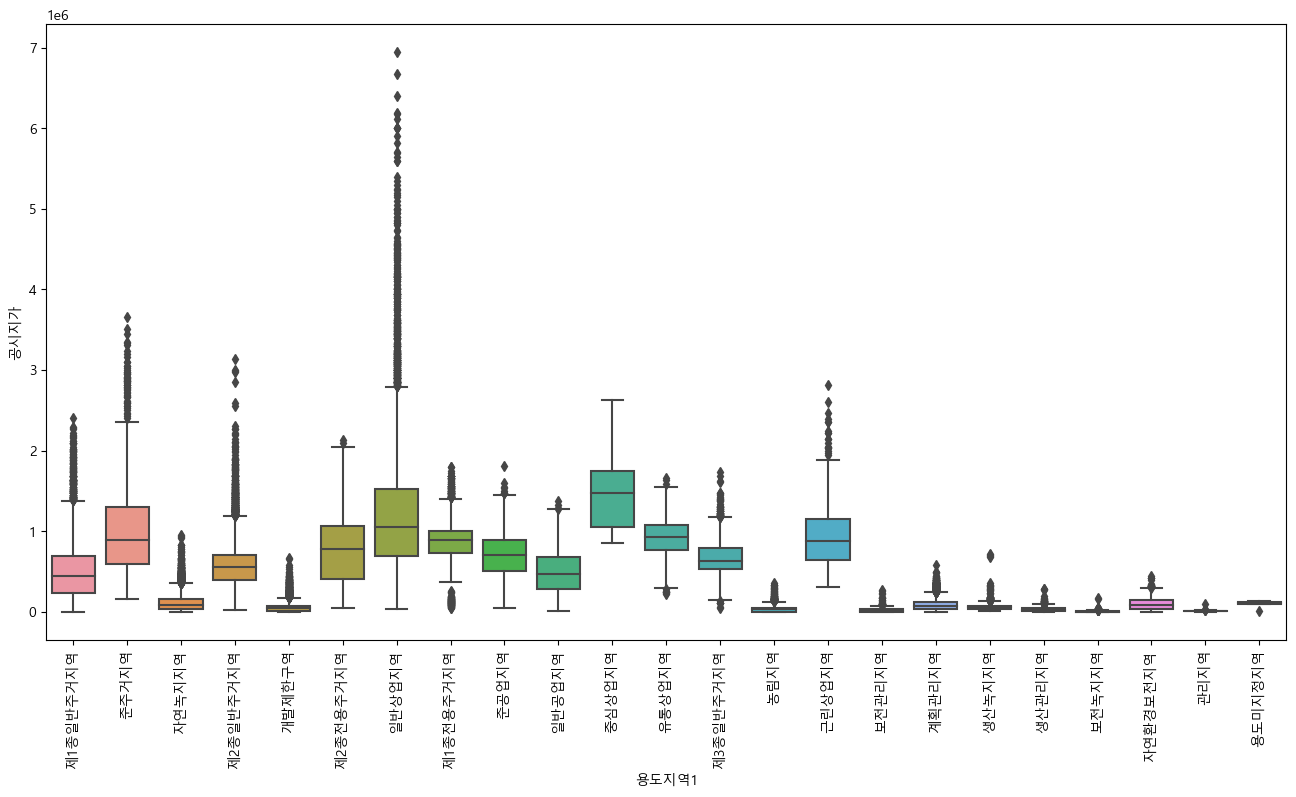

In [92]:
df['용도지역1']
plt.figure(figsize=(16,8))
sns.boxplot(data=df, x='용도지역1', y='공시지가')
plt.xticks(rotation=90)
plt.show()

In [93]:
yongdo_value = df['용도지역1'].value_counts()
fig = go.Figure(data=[go.Pie(labels=df['용도지역1'].unique(), values=yongdo_value, hole=0.4, pull=[0,0,0,0,0,0,0.2,0,0,0,0.2])])
fig.update_layout(width=800, height=650, title={
    'text': '창원시 용도지역별 분포',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 35}
})

fig.show()

In [94]:
yongdo_year = df.groupby(['연도', '용도지역1'])['공시지가'].mean().reset_index()

# 그래프 그리기
fig = px.bar(yongdo_year, x='용도지역1', y='공시지가', animation_frame='연도', range_y=[0, max(yongdo_year['공시지가'])],
             color='용도지역1', labels={'용도지역1': '용도지역', '공시지가': '공시지가'},
             title='지목별 공시지가 변화')
fig.update_layout(width=1600, height=600,
    xaxis={'categoryorder': 'array', 'categoryarray': ['A', 'B', 'C']},
                  title={
    'text': '용도지역별 공시지가 평균의 변화',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 35}
})
fig.update_layout()
fig.show()

# 지세, 형상, 도로교통에 따른 분석
> 세 가지의 조건으로 공시지가 분석 및 그래프

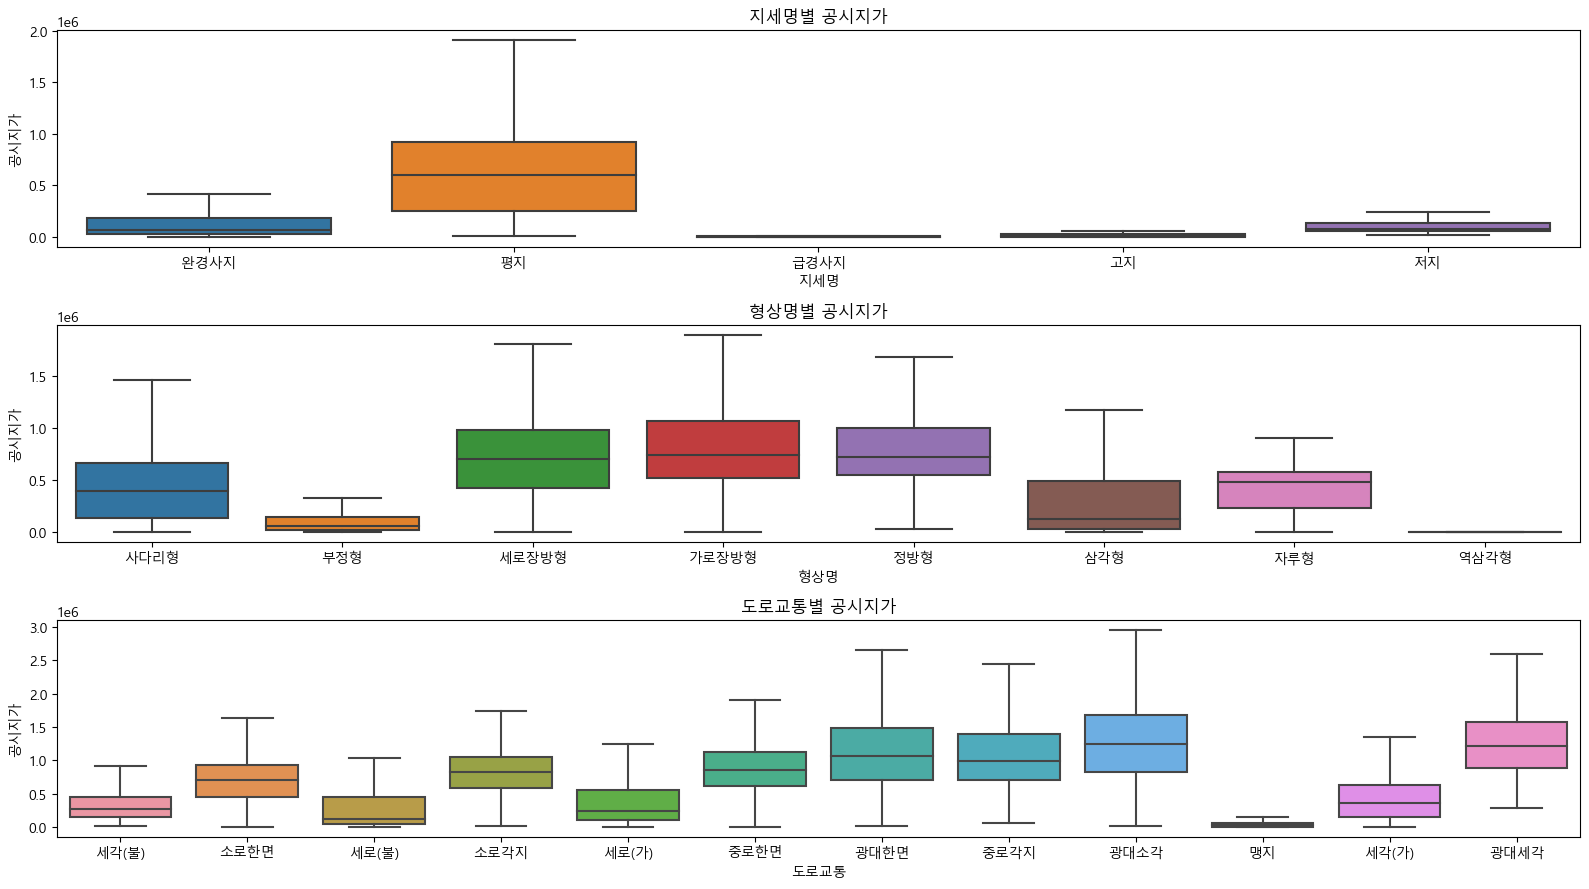

In [95]:
fig, axes = plt.subplots(3, 1, figsize=(16, 9))
lst = ['지세명', '형상명', '도로교통']
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(data=df, x=lst[i], y='공시지가', showfliers=False, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_title(f'{lst[i]}별 공시지가')
plt.tight_layout()
plt.show()

In [96]:
# 지세별 평균 공시지가
jise_year = df.groupby(['연도', '지세명'])['공시지가'].mean().reset_index()

# 그래프 그리기
fig = px.bar(jise_year, x='지세명', y='공시지가', animation_frame='연도', range_y=[0, max(jise_year['공시지가'])],
             color='지세명', labels={'지세명': '용도지역', '공시지가': '공시지가'},
             title='지세별 공시지가 변화')
fig.update_layout(width=1200, height=600,
    xaxis={'categoryorder': 'array', 'categoryarray': ['A', 'B', 'C']},
                  title={
    'text': '지세별 평균 공시지가의 변화',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 35}
})
fig.update_layout()
fig.show()

In [97]:
# 지세별 평균 공시지가
# 데이터셋 불러오기
shapes = df.groupby(['연도', '지세명'])['공시지가'].mean().reset_index()

# 고유한 지세명과 색상 매핑
color_map = {'고지': 'red', '급경사지': 'blue', '완경사지': 'coral', '저지': 'green', '평지': 'turquoise'}

# 라인 그래프 그리기
fig = go.Figure()
for jise_name, color in color_map.items():
    jise_data = shapes[shapes['지세명'] == jise_name]
    fig.add_trace(go.Scatter(x=jise_data['연도'], y=jise_data['공시지가'], mode='lines', line=dict(color=color), name=jise_name))

# 레이아웃 설정
fig.update_layout(width=1200, height=600,
    title={
        'text': '지세명별 평균 공시지가의 변화',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 35}
    },
    xaxis_title='연도',
    yaxis_title='공시지가',
    legend_title='지세명'
)

fig.show()

In [98]:
# 형상명별 평균 공시지가
shape_year = df.groupby(['연도', '형상명'])['공시지가'].mean().reset_index()

# 그래프 그리기
fig = px.bar(shape_year, x='형상명', y='공시지가', animation_frame='연도', range_y=[0, max(shape_year['공시지가'])],
             color='형상명', labels={'형상명': '용도지역', '공시지가': '공시지가'},
             title='지세별 공시지가 변화')
fig.update_layout(width=1200, height=600,
    xaxis={'categoryorder': 'array', 'categoryarray': ['A', 'B', 'C']},
                  title={
    'text': '형상명별 평균 공시지가의 변화',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 35}
})
fig.update_layout()
fig.show()

In [99]:
# 지세별 평균 공시지가
# 데이터셋 불러오기
shapes = df.groupby(['연도', '형상명'])['공시지가'].mean().reset_index()

# 고유한 지세명과 색상 매핑
color_map = {'가로방장형': 'red', '부정형': 'blue', '사다리형': 'green', '세로장방형': 'coral', '정방형': 'turquoise', '자루형':'magenta', '삼각형':'yellow', '역삼각형':'purple'}

# 라인 그래프 그리기
fig = go.Figure()
for jise_name, color in color_map.items():
    jise_data = shapes[shapes['형상명'] == jise_name]
    fig.add_trace(go.Scatter(x=jise_data['연도'], y=jise_data['공시지가'], mode='lines', line=dict(color=color), name=jise_name))

# 레이아웃 설정
fig.update_layout(width=1200, height=600,
    title={
        'text': '형상별 평균 공시지가의 변화',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 35}
    },
    xaxis_title='연도',
    yaxis_title='공시지가',
    legend_title='형상명'
)

fig.show()

In [100]:
# 지세별 평균 공시지가
doro_year = df.groupby(['연도', '도로교통'])['공시지가'].mean().reset_index()

# 그래프 그리기
fig = px.bar(doro_year, x='도로교통', y='공시지가', animation_frame='연도', range_y=[0, max(doro_year['공시지가'])],
             color='도로교통', labels={'도로교통': '용도지역', '공시지가': '공시지가'},
             title='지세별 공시지가 변화')
fig.update_layout(width=1400, height=600,
    xaxis={'categoryorder': 'array', 'categoryarray': ['A', 'B', 'C']},
                  title={
    'text': '도로교통별 평균 공시지가의 변화',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 35}
})
fig.update_layout()
fig.show()

* 광로 : 40m 이상
* 대로 : 25m 이상 40m 미만 
* 중로 : 12m 이상 25m 미만
* 소로 : 8m 이상 12m 미만
* 세로 : 8m 미만

In [101]:
# 지세별 평균 공시지가
# 데이터셋 불러오기
shapes = df.groupby(['연도', '도로교통'])['공시지가'].mean().reset_index()

# 고유한 지세명과 색상 매핑
color_map = {'광대세각': 'red', '광대소각': 'blue', '광대한면': 'green', '소로각지': 'coral', '소로한면': 'turquoise', 
             '중로각지': 'magenta', '중로한면': 'yellow', '맹지': 'purple', '세각(가)': 'pink', '세각(불)': 'gold',
             '세로(가)': 'gray', '세로(불)': 'brown'}
# 라인 그래프 그리기
fig = go.Figure()
for jise_name, color in color_map.items():
    jise_data = shapes[shapes['도로교통'] == jise_name]
    fig.add_trace(go.Scatter(x=jise_data['연도'], y=jise_data['공시지가'], mode='lines', line=dict(color=color), name=jise_name))

# 레이아웃 설정
fig.update_layout(width=1200, height=600,
    title={
        'text': '도로교통별 평균 공시지가의 변화',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 35}
    },
    xaxis_title='연도',
    yaxis_title='공시지가',
    legend_title='도로교통'
)

fig.show()

# 이상치 제거 어떻게 할까

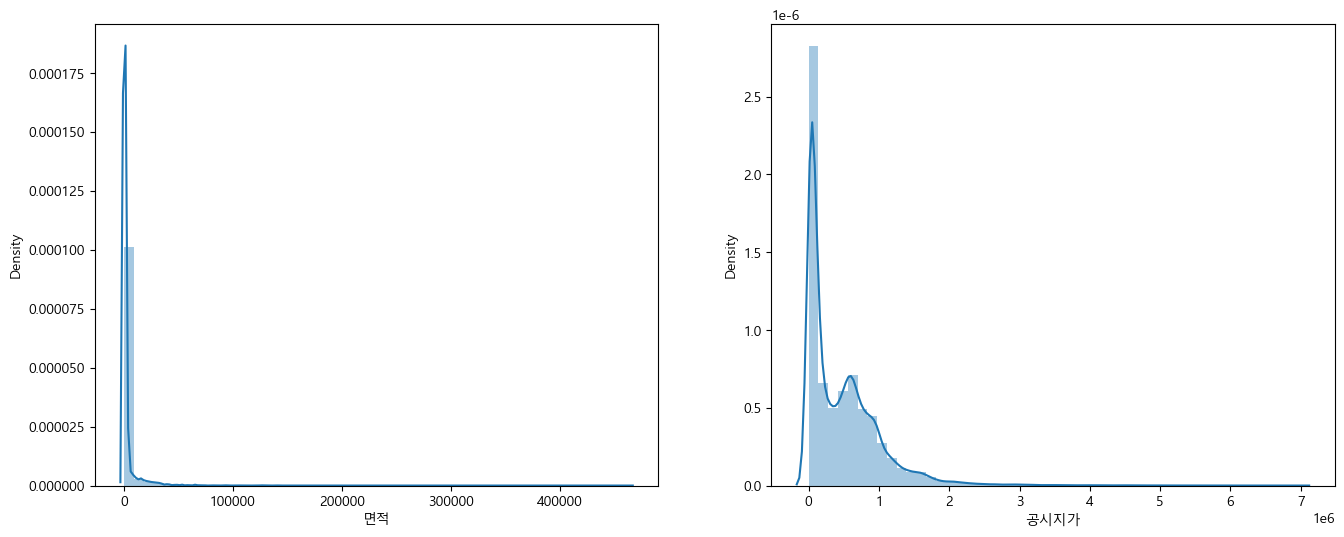

In [102]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))
sns.distplot(df['면적'], ax=ax1)
sns.distplot(df['공시지가'], ax=ax2)

plt.show()

In [103]:
df[df['면적'] >= 200000].sort_values(by='공시지가', ascending=False)

,시군구,읍면동리,지번구분,본번지,부번지,시도명,시군구명,소재지,지목,면적,용도지역1,이용상황,주위환경,지세명,형상명,도로교통,공시지가,연도,가격
4950329,48123,12800,1,0028,0,경상남도,창원성산구,성주동 28,공장용지,249896.7,일반공업지역,공업용,산업단지,평지,사다리형,광대한면,578000,2021,1.444403e+11
3932773,48123,12800,1,28,0,경상남도,창원성산구,성주동 28,공장용지,249896.7,일반공업지역,공업용,산업단지,평지,사다리형,광대소각,560000,2019,1.399422e+11
4432734,48123,12800,1,28,0,경상남도,창원성산구,성주동 28,공장용지,249896.7,일반공업지역,공업용,산업단지,평지,사다리형,광대소각,560000,2020,1.399422e+11
3432835,48123,12800,1,28,0.0,경상남도,창원성산구,성주동 28,공장용지,249896.7,일반공업지역,공업용,산업단지,평지,사다리형,광대한면,560000,2018,1.399422e+11
2887216,48123,12800,1,28,0,경상남도,창원성산구,성주동 28,공장용지,249896.7,일반공업지역,공업용,산업단지,평지,사다리형,광대한면,543000,2017,1.356939e+11
2433128,48123,12800,1,28,NaN,경상남도,창원성산구,성주동,공장용지,250540.9,일반공업지역,공업용,산업단지,평지,사다리형,광대한면,505000,2016,1.265232e+11
1933194,48123,12800,1,0028,0,경상남도,창원성산구,성주동 28,공장용지,250540.9,일반공업지역,공업용,산업단지,평지,사다리형,광대한면,500000,2015,1.252704e+11
1433209,48123,12800,1,0028,0000,경상남도,창원성산구,성주동 28,공장용지,250540.9,일반공업지역,공업용,산업단지,평지,사다리형,광대한면,470000,2014,1.177542e+11
933228,48123,12800,1,0028,0000,경상남도,창원성산구,성주동 28,공장용지,250540.9,일반공업지역,공업용,산업단지,평지,사다리형,광대한면,430000,2013,1.077326e+11
433221,48123,12800,1,0028,0000,경상남도,창원성산구,성주동 28,공장용지,250540.9,일반공업지역,공업용,산업단지,평지,사다리형,광대한면,400000,2012,1.002164e+11


In [10]:
df = df.drop(df[df['면적'] >= 2000000].index)

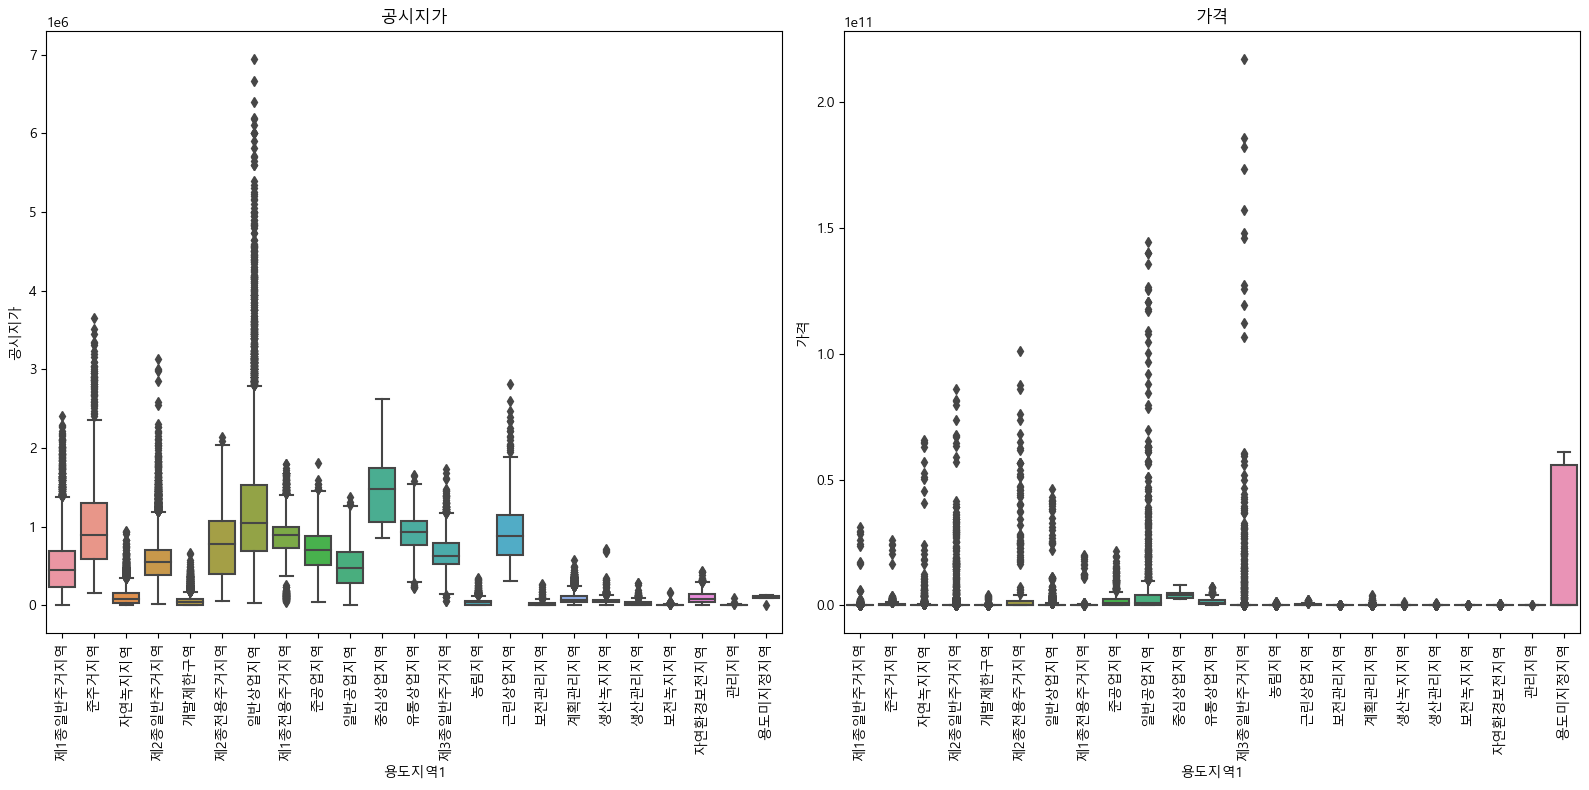

In [105]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8))
sns.boxplot(x=df['용도지역1'], y=df['공시지가'], ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('공시지가')
sns.boxplot(x=df['용도지역1'], y=df['가격'], ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title('가격')
plt.tight_layout()
plt.show()

In [106]:
df[df['용도지역1'] == '용도미지정지역']

,시군구,읍면동리,지번구분,본번지,부번지,시도명,시군구명,소재지,지목,면적,용도지역1,이용상황,주위환경,지세명,형상명,도로교통,공시지가,연도,가격
435535,48125,34021,1,0336,0002,경상남도,창원마산합포구,진전면 율티리 336-2,잡종지,585.0,용도미지정지역,주거나지,미성숙 주택지대,평지,사다리형,세로(가),95000,2012,5.557500e+07
935542,48125,34021,1,0336,0002,경상남도,창원마산합포구,진전면 율티리 336-2,잡종지,585.0,용도미지정지역,주거나지,미성숙 주택지대,평지,사다리형,세로(가),99000,2013,5.791500e+07
1435524,48125,34021,1,0336,0002,경상남도,창원마산합포구,진전면 율티리 336-2,잡종지,585.0,용도미지정지역,주거나지,미성숙 주택지대,평지,사다리형,세로(가),104000,2014,6.084000e+07
1932351,48121,31028,2,0097,1,경상남도,창원의창구,북면 감계리 산97-1,임야,8610.0,용도미지정지역,자연림,순수 산림지대,급경사지,사다리형,맹지,4500,2015,3.874500e+07
1935500,48125,34021,1,0336,2,경상남도,창원마산합포구,진전면 율티리 336-2,잡종지,585.0,용도미지정지역,주거나지,미성숙 주택지대,평지,사다리형,세로(가),110000,2015,6.435000e+07
2435438,48125,34021,1,336,NaN,경상남도,창원마산합포구,율티리,잡종지,585.0,용도미지정지역,주거나지,미성숙 주택지대,평지,사다리형,세로(가),116000,2016,6.786000e+07
3937541,48129,15200,1,297,0,경상남도,창원진해구,수도동 297,잡종지,463826.3,용도미지정지역,매립,미개발지대,평지,세로장방형,광대한면,120000,2019,5.565916e+10
4437468,48129,15200,1,297,0,경상남도,창원진해구,수도동 297,잡종지,463826.3,용도미지정지역,매립,미개발지대,평지,세로장방형,광대한면,120000,2020,5.565916e+10
4955372,48129,15200,1,0297,0,경상남도,창원진해구,수도동 297,잡종지,463826.3,용도미지정지역,공업나지,산업단지,평지,세로장방형,광대한면,131500,2021,6.099316e+10


In [11]:
df = df.drop(df[df['용도지역1'] == '용도미지정지역'].index)

# 모델 학습을 위한 데이터 가공
> 특성 선택 및 원핫인코딩

In [12]:
# X, y 분리
X_original = original.drop(['공시지가'], axis=1)
X_df = df.drop(['공시지가', '가격'], axis=1)
y_original = original['공시지가']
y_df = df['공시지가']
X_2022 = df_2022.drop(['공시지가'], axis=1)
y_2022 = df_2022['공시지가']

In [16]:
# 라벨 인코딩
le = LabelEncoder()
lst = ['시도명', '시군구명', '소재지', '지목', '용도지역1', '이용상황', '주위환경', '지세명', '형상명', '도로교통', '본번지', '부번지']

for i in lst:
    X_df[i] = le.fit_transform(X_df[i].astype(str))
    X_original[i] = le.fit_transform(X_original[i].astype(str))
    X_2022[i] = le.fit_transform(X_2022[i].astype(str))

# X_df['본번지'] = le.fit_transform(X_df['본번지'])
# X_df['부번지'] = le.fit_transform(X_df['부번지'])
# X_original['본번지'] = le.fit_transform(X_original['본번지'])
# X_original['부번지'] = le.fit_transform(X_original['부번지'])
# X_2022['본번지'] = le.fit_transform(X_2022['본번지'])
# X_2022['부번지'] = le.fit_transform(X_2022['부번지'])

# 수치형 열 표준화
mmscaler = MinMaxScaler()
mmlst = ['면적']

for i in mmlst:
    X_df[i] = mmscaler.fit_transform(X_df[[i]])
    X_original[i] = mmscaler.fit_transform(X_original[[i]])
    X_2022[i] = mmscaler.fit_transform(X_2022[[i]])

# original_sc = mmscaler.fit_transform(X_original)
# df_sc = mmscaler.fit_transform(X_df)
# X_2022_sc = mmscaler.fit_transform(X_2022)

In [54]:
# # One-Hot Encoding 적용
# original_encoded = pd.get_dummies(X_original)
# df_encoded = pd.get_dummies(X_df)

# # 수치형 열 표준화
# mmscaler = MinMaxScaler()
# original_numeric = mmscaler.fit_transform(original_encoded)
# df_numeric = mmscaler.fit_transform(df_encoded)

# 차원축소 PCA

In [17]:
# PCA 수행
pca = PCA(n_components=3)
original_pca = pca.fit_transform(original_sc)
df_pca = pca.fit_transform(df_sc)

print(original_pca.shape)
print(df_pca.shape)

# 데이터 나누기 train_test_split

In [19]:
# df 데이터 나누기
X_train_val, X_test, y_train_val, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1)

# original 데이터 나누기
X_train_val_original, X_test_original, y_train_val_original, y_test_original = train_test_split(X_original, y_original, test_size=0.2, random_state=1)
X_train_original, X_val_original, y_train_original, y_val_original = train_test_split(X_train_val_original, y_train_val_original, test_size=0.25, random_state=1)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_original.shape, X_val_original.shape, X_test_original.shape)

(43640, 17) (14547, 17) (14547, 17)
(3012000, 17) (1004000, 17) (1004000, 17)


## <b> 3. 모델 학습 및 검증 </b>

>일반적으로 '공시지가'가 매해 증가한다는 점을 고려하여 선형회귀를 모델로 선정함.

# XGBoost
> 모델 학습 및 val set

Validation Set:
MAE: 72916.48652580011
MSE: 20358447260.05362
RMSE: 142683.03073615173
MAPE: 0.7295899966210895


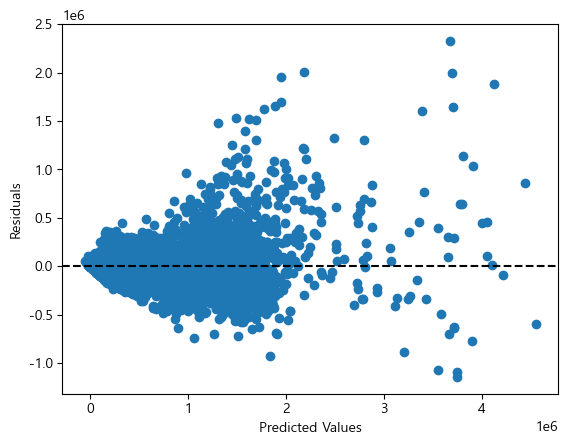

In [20]:
# XGBoost 모델 생성
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', n_estimators=100, max_depth=5, learning_rate=0.1, random_state=1)

# 모델 학습
xgb_model.fit(X_train, y_train)

# 모델 예측
y_pred = xgb_model.predict(X_val)

# 모델 평가
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_val, y_pred)

print('Validation Set:')
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE:', mape)

# 잔차 그래프 그리기
residuals = y_val - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

> 학습곡선

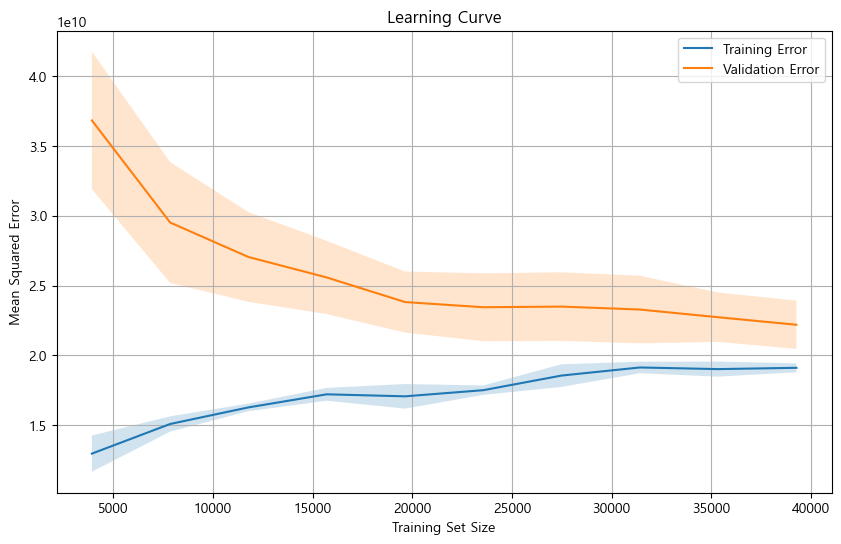

In [22]:
# 학습곡선
sizes, train_scores, val_scores = learning_curve(estimator=xgb_model, X=X_train, y=y_train,
                                                train_sizes=np.linspace(0.1, 1.0, 10),
                                                cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(sizes, train_mean, label='Training Error')
plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(sizes, val_mean, label='Validation Error')
plt.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.grid(True)
plt.show()

> 검증곡선

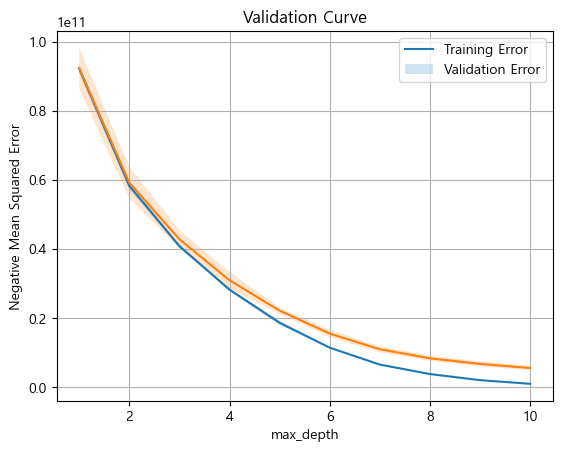

In [23]:
# 검증곡선
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_scores, test_scores = validation_curve(xgb_model, X_train, y_train, param_name="max_depth", 
                                             param_range=param_range, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(param_range, train_mean)
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.2)

plt.plot(param_range, test_mean)
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.2)

plt.xlabel('max_depth')
plt.ylabel('Negative Mean Squared Error')
plt.title('Validation Curve')
plt.legend(['Training Error', 'Validation Error'])
plt.grid(True)
plt.show()

> XGBoost test set

Test Set:
MAE: 73795.15846484045
MSE: 21803044709.647453
RMSE: 147658.5409302403
MAPE: 0.7277550134266236


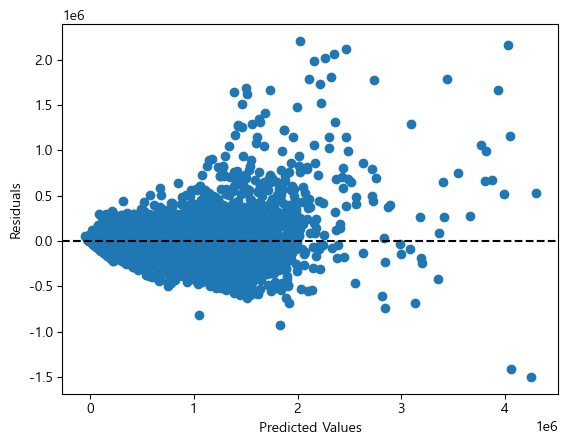

In [21]:
y_test_pred = xgb_model.predict(X_test)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print('Test Set:')
print('MAE:', mae_test)
print('MSE:', mse_test)
print('RMSE:', rmse_test)
print('MAPE:', mape_test)

# 잔차 그래프 그리기
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

# XGBoots로 2022년 창원시 공시지가 예측

Test Set:
MAE: 151194.59712757534
MSE: 82229319813.46928
RMSE: 286756.5514743635
MAPE: 1.1189529629871107


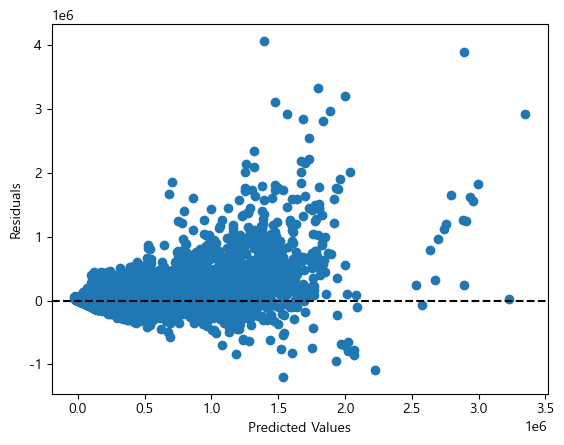

In [24]:
y_test_pred = xgb_model.predict(X_2022)

mse_test = mean_squared_error(y_2022, y_test_pred)
mae_test = mean_absolute_error(y_2022, y_test_pred)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_2022, y_test_pred)

print('Test Set:')
print('MAE:', mae_test)
print('MSE:', mse_test)
print('RMSE:', rmse_test)
print('MAPE:', mape_test)

# 잔차 그래프 그리기
residuals = y_2022 - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

# RandomForestRegressor
> 모델 학습 및 val set

Validation Set:
MAE: 136305.6331020181
MSE: 69964816061.69226
RMSE: 264508.6313557504
MAPE: 1.3215550657688948


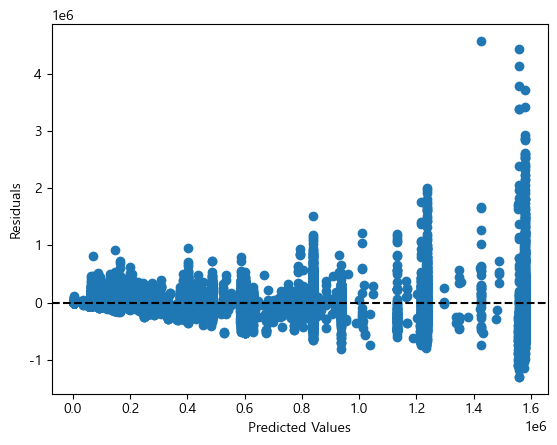

In [25]:
rf = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=4, min_samples_leaf=1, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)
rmse = np.sqrt(mse)

print('Validation Set:')
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE:', mape)

# 잔차 그래프 그리기
residuals = y_val - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

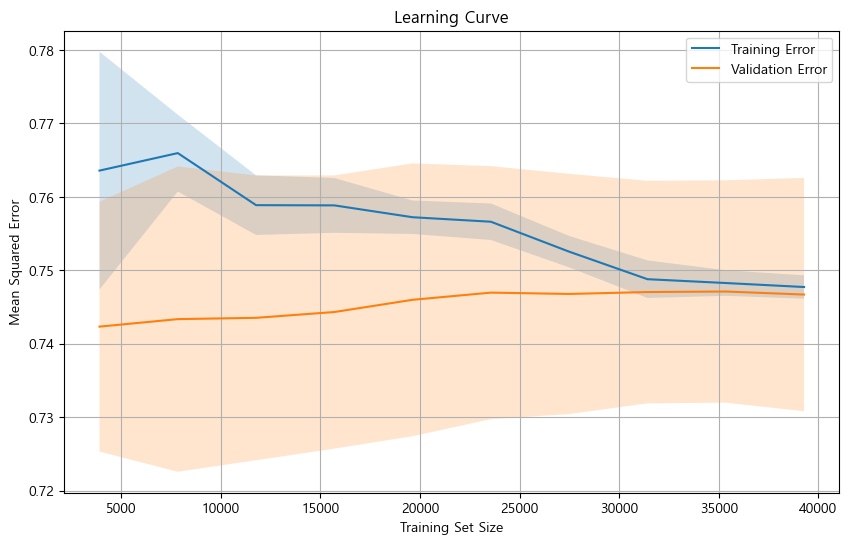

In [27]:
# 학습곡선
sizes, train_scores, val_scores = learning_curve(estimator=rf, X=X_train, y=y_train,
                                                train_sizes=np.linspace(0.1, 1.0, 10),
                                                cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(sizes, train_mean, label='Training Error')
plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(sizes, val_mean, label='Validation Error')
plt.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.grid(True)
plt.show()

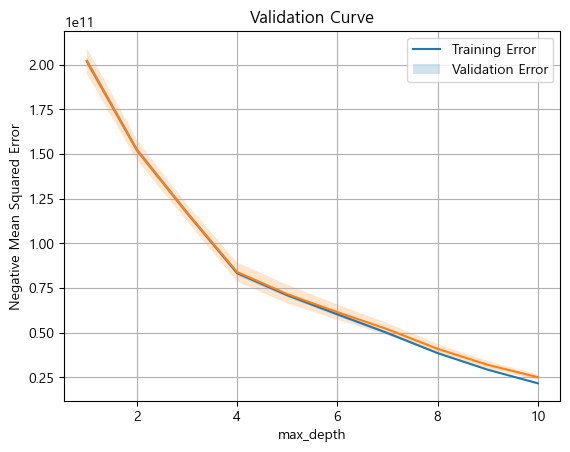

In [28]:
# Define the parameter range to test
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Calculate the training and test scores for different max_depth values
train_scores, test_scores = validation_curve(rf, X_train, y_train, param_name="max_depth", 
                                             param_range=param_range, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

# Calculate the mean and standard deviation of the training and test scores
train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure()
plt.plot(param_range, train_mean)
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.2)

plt.plot(param_range, test_mean)
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.2)

plt.xlabel('max_depth')
plt.ylabel('Negative Mean Squared Error')
plt.title('Validation Curve')
plt.legend(['Training Error', 'Validation Error'])
plt.grid(True)
plt.show()

> test set

Test Set:
MAE: 134632.60317417557
MSE: 67421124453.86514
RMSE: 259655.78070565875
MAPE: 1.2038163402168984


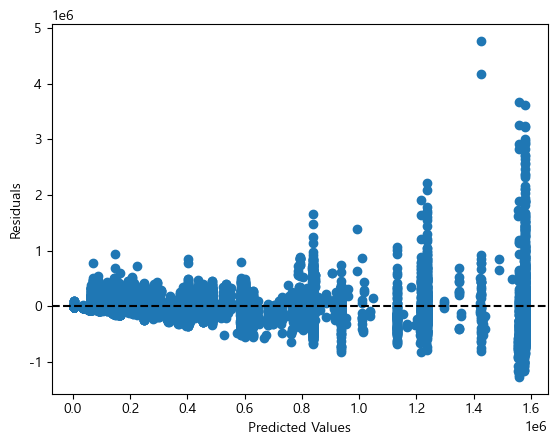

In [26]:
y_test_pred = rf.predict(X_test)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print('Test Set:')
print('MAE:', mae_test)
print('MSE:', mse_test)
print('RMSE:', rmse_test)
print('MAPE:', mape_test)

# 잔차 그래프 그리기
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

# RandomForestRegressor 2022년 창원시 공시지가 예측

Test Set:
MAE: 195623.46108510793
MSE: 126247126302.82047
RMSE: 355312.71621322597
MAPE: 0.939575657737871


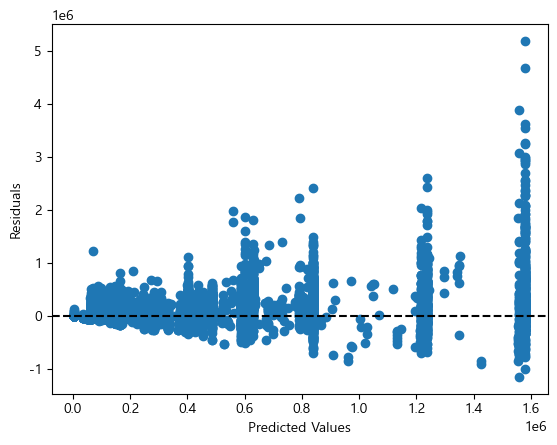

In [29]:
y_test_pred = rf.predict(X_2022)

mse_test = mean_squared_error(y_2022, y_test_pred)
mae_test = mean_absolute_error(y_2022, y_test_pred)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_2022, y_test_pred)

print('Test Set:')
print('MAE:', mae_test)
print('MSE:', mse_test)
print('RMSE:', rmse_test)
print('MAPE:', mape_test)

# 잔차 그래프 그리기
residuals = y_2022 - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

In [201]:
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [3, 5, 7],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 2, 4]}

rf = RandomForestRegressor(random_state=1)
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
gs.fit(X_train, y_train)
best_model = gs.best_estimator_
y_pred = best_model.predict(X_2022)

# 모델 평가
mse = mean_squared_error(y_2022, y_pred)
mae = mean_absolute_error(y_2022, y_pred)
rmse = np.sqrt(mse)
mape_test = mean_absolute_percentage_error(y_2022, y_pred)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE:', mape_test)

# 잔차 그래프 그리기
residuals = y_2022 - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

KeyboardInterrupt: 

> <b> (작업 내용 작성 예) </b> 훈련 데이터와 테스트 데이터에 대한 정확도는 각각 96%, 83%로 확인됨.

In [23]:
# 코드 및 결과

## <b> 4. 결과 분석 및 고찰 </b>

> * 전체 프로젝트 과정을 간략하게 기술
> * 예측 결과를 분석하고 추가 및 보완해야 할 점을 기술

예) 땅을 넓히는 것? 길을 내는 것? 어느 쪽이 더 공시지가가 올라가는지  
더 다듬을 수 있다면, 작업을 더 개선할 수 있을만한 사안